In [1]:
import re
import numpy as np
import pandas as pd

import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.tokenize import word_tokenize
from tqdm import tqdm


In [2]:
train_df = pd.read_csv("/kaggle/input/data-255-toxic-comment-in-class-competition/train.csv").fillna(' ')
train_df.head()

,id,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,0,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
1,1,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
2,2,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
3,3,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
4,4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.0,0.87234,0.021277,0.0


In [3]:
train_df.describe()

,id,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,9.024365e+05,1.030173e-01,4.582099e-03,1.387721e-02,9.311271e-03,8.115273e-02,2.263571e-02,6.605974e-03
std,5.210224e+05,1.970757e-01,2.286128e-02,6.460419e-02,4.942218e-02,1.760657e-01,7.873156e-02,4.529782e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.512182e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.024365e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.353655e+06,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000e+00
max,1.804873e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
test_df = pd.read_csv("/kaggle/input/data-255-toxic-comment-in-class-competition/test.csv").fillna(' ') #fill missing values with space
test_df.head(10)

,id,text
0,0,[ Integrity means that you pay your debts.]\n\...
1,1,This is malfeasance by the Administrator and t...
2,2,@Rmiller101 - Spoken like a true elitist. But ...
3,3,"Paul: Thank you for your kind words. I do, in..."
4,4,Sorry you missed high school. Eisenhower sent ...
5,5,Let’s see if I understand this; Berkowitz anno...
6,6,Our oils read; President IS taking different ...
7,7,'Work together'? Dream on. The liberals are al...
8,8,What would Jerry Prevo think about that story?...
9,9,When wil the indigenous be accountable and t...


In [5]:
test_df.describe()

,id
count,97320.000000
mean,48659.500000
std,28094.008436
min,0.000000
25%,24329.750000
50%,48659.500000
75%,72989.250000
max,97319.000000


In [6]:
test_df.info

<bound method DataFrame.info of           id                                               text
0          0  [ Integrity means that you pay your debts.]\n\...
1          1  This is malfeasance by the Administrator and t...
2          2  @Rmiller101 - Spoken like a true elitist. But ...
3          3  Paul: Thank you for your kind words.  I do, in...
4          4  Sorry you missed high school. Eisenhower sent ...
...      ...                                                ...
97315  97315  He should lose his job for promoting mis-infor...
97316  97316  "Thinning project is meant to lower fire dange...
97317  97317  I hope you millennials are happy that you put ...
97318  97318  I'm thinking Kellyanne Conway (a.k.a. The Trum...
97319  97319  I still can't figure why a pizza in AK cost mo...

[97320 rows x 2 columns]>

In [7]:
print("Training data shape: ",train_df.shape)
print("Testing data shape: ",test_df.shape)

Training data shape:  (1804874, 9)
Testing data shape:  (97320, 2)


In [8]:
train_df  = train_df.drop(['id'],axis = 1)
test_df   = test_df.drop(['id'],axis = 1)

In [9]:
null_tr = train_df.isnull().sum()
print("Null values in training set: ")
print(null_tr)
print()
null_test = test_df.isnull().sum()
print("Null values in testing set: ")
print( null_test)
print()

Null values in training set: 
text               0
toxicity           0
severe_toxicity    0
obscene            0
threat             0
insult             0
identity_attack    0
sexual_explicit    0
dtype: int64

Null values in testing set: 
text    0
dtype: int64



In [10]:
def clean_text(line):

    clean_t = ""
    line = line.replace("’", "")  #replace these symbols with spaces(" ") or no space("")
    line = line.replace("'", "")
    line = line.replace("=", "")
    line = line.replace("-", " ")
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'zxcvbnmlkjhgfdsaqwertyuiop ':
            clean_t += char
        else:
            clean_t += ' '

    clean_t = re.sub(' +',' ',clean_t) #delete extra spaces

    return clean_t

In [11]:
# clean text
train_df['text'] = train_df['text'].apply(lambda x: clean_text(x))
test_df['text']  = test_df['text'].apply(lambda x: clean_text(x))

In [12]:
x = train_df["text"].values
print(x)

['this is so cool its like would you want your mother to read this really great idea well done '
 'thank you this would make my life a lot less anxiety inducing keep it up and dont let anyone get in your way '
 'this is such an urgent design problem kudos to you for taking it on very impressive '
 ... 'thank you right or wrong i am following your advice'
 'anyone who is quoted as having the following exchange even if apocryphal would have received my vote bessie braddock winston you are drunk and whats more you are disgustingly drunk winston churchill bessie my dear you are ugly and whats more you are disgustingly ugly but tomorrow i shall be sober and you will still be disgustingly ugly '
 'students defined as ebd are legally just as disabled and eligible for special services as a developmentally disabled or physically disabled student emotional and behavioral disorder ebd definition an emotional and behavioral disorder is an emotional disability characterized by the following i an in

In [13]:
list_class = ["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack","sexual_explicit"]
y = train_df[list_class].values
print(y)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.6212121  0.03030303 0.03030303 ... 0.6212121  0.04545455 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [14]:
x_test = test_df['text'].values
print(x_test)

[' integrity means that you pay your debts does this apply to president trump too '
 'this is malfeasance by the administrator and the board they are wasting our money '
 ' rmiller spoken like a true elitist but look out bud the re awakening in europe brexit and now the trump victory are just the beginning the unwashed masses are coming for you and your ilk '
 ...
 'i hope you millennials are happy that you put this airhead in charge '
 'im thinking kellyanne conway a k a the trump whisperer will play a very large role in the trump administration and as crazy as this sounds that might be a good thing '
 'i still cant figure why a pizza in ak cost more than a pizza in washington idaho kentucky etc etc the only answer i get is shipping charges i guess costco does not incur a shipping charge because there is no price difference if i am going to be charged extra at least the tv commercials for ak should show the actual prices i sure as heck dont make anymore income here than i do in wa soc

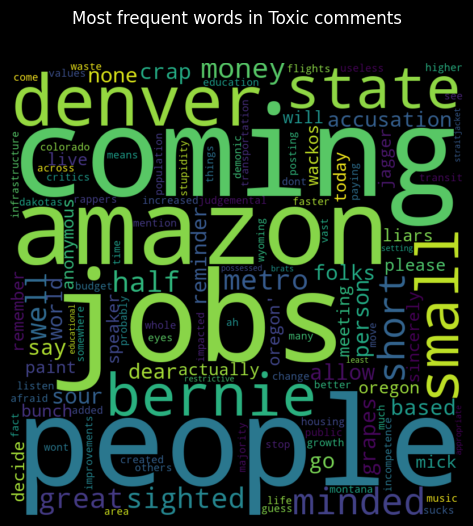

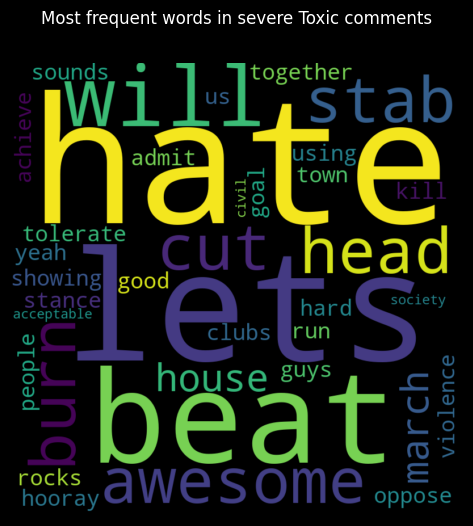

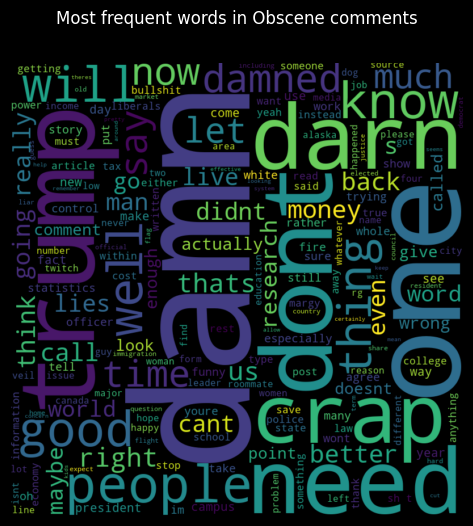

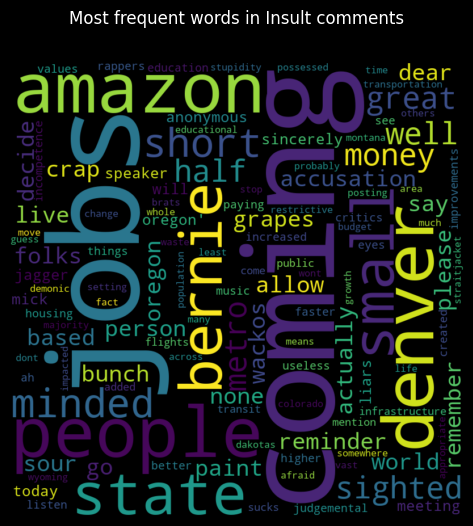

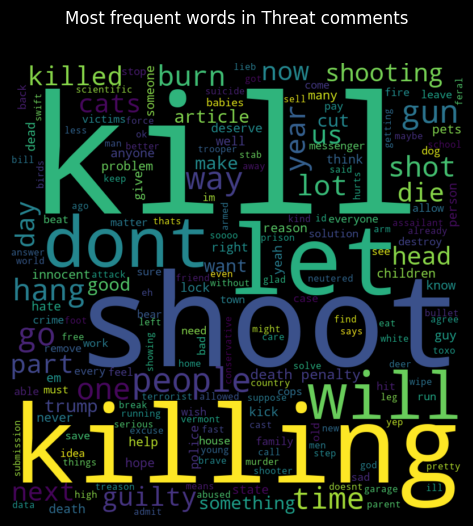

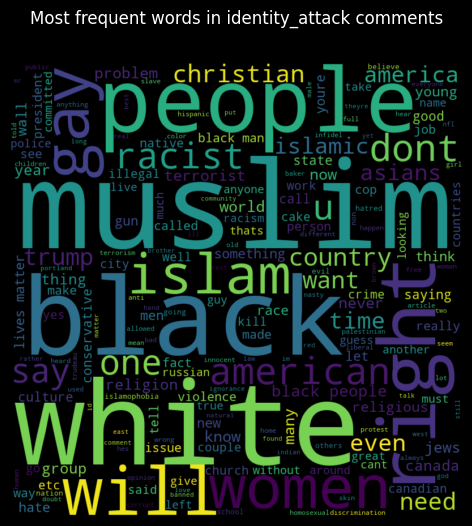

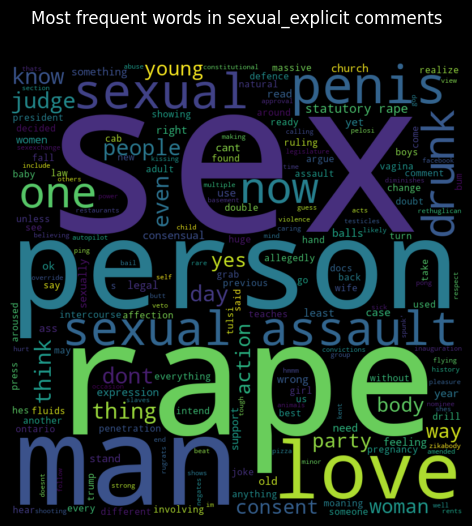

In [15]:
def word_plot(column,text):
    
    comments = train_df['text'].loc[column == 1].values     # sort by toxicity
    
    word_cloud = WordCloud( width = 800, height = 800,
                stopwords = STOPWORDS).generate(str(comments))     # stopwords are a,an,the
    
    fig = plt.figure( figsize = (8, 5), facecolor = 'k', edgecolor = 'k')
    plt.subplot()
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.suptitle("Most frequent words in " +  text , y = 1.06,color = "white")
    plt.tight_layout(pad = 0)
    plt.axis('off')
    plt.show()
    
word_plot(train_df['toxicity'], "Toxic comments")
word_plot(train_df['severe_toxicity'],"severe Toxic comments")
word_plot(train_df['obscene'],"Obscene comments")
word_plot(train_df['insult'],"Insult comments")
word_plot(train_df['threat'],"Threat comments")
word_plot(train_df['identity_attack'],"identity_attack comments")
word_plot(train_df['sexual_explicit'],"sexual_explicit comments")

In [16]:
#Count words
count_word = train_df["text"].apply(lambda x: len(str(x).split()))

#Unique word count
count_unique_word = train_df["text"].apply(lambda x: len(set(str(x).split())))

In [17]:
unique_percent = count_unique_word*100/count_word
unique_percent

0           94.736842
1          100.000000
2          100.000000
3           94.117647
4          100.000000
              ...    
1804869     86.486486
1804870    100.000000
1804871    100.000000
1804872     65.517241
1804873     71.755725
Name: text, Length: 1804874, dtype: float64

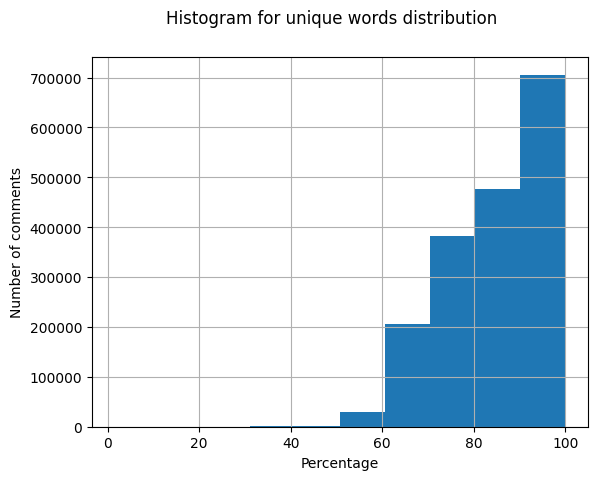

In [18]:
unique_percent.hist()
plt.suptitle("Histogram for unique words distribution")
plt.xlabel("Percentage")
plt.ylabel("Number of comments")
plt.show()

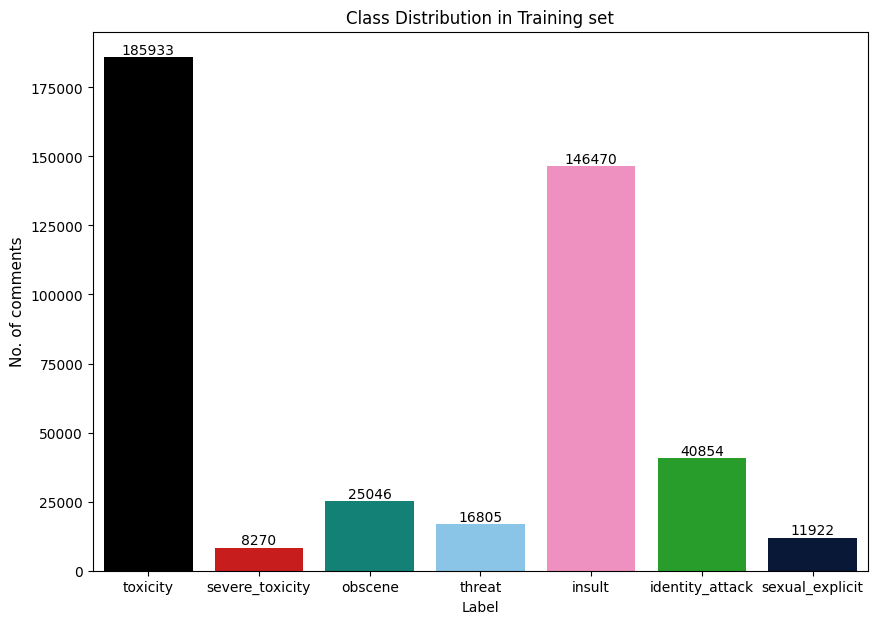

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


colors_ = ["black", "red", "teal", "lightblue", "pink", "green", "navy"]
palette = sns.xkcd_palette(colors_)

x = train_df.iloc[:, 1:].sum()

# Create a bar plot
plt.figure(figsize=(10,7))
ax = sns.barplot(x=x.index, y=x.values, palette=palette)

# Set plot title and labels
plt.title("Class Distribution in Training set")
plt.xlabel('Label')
plt.ylabel('No. of comments', fontsize=11)

# Add the value labels on top of the bars
patch = ax.patches
labels = x.values
for rect, label in zip(patch, labels):
    height = rect.get_height()
    # Place the labels a little above the top of each bar to avoid overlap
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, int(label), va='bottom', ha='center')

# Display the plot
plt.show()


/tmp/ipykernel_23/2635369167.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_df.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)


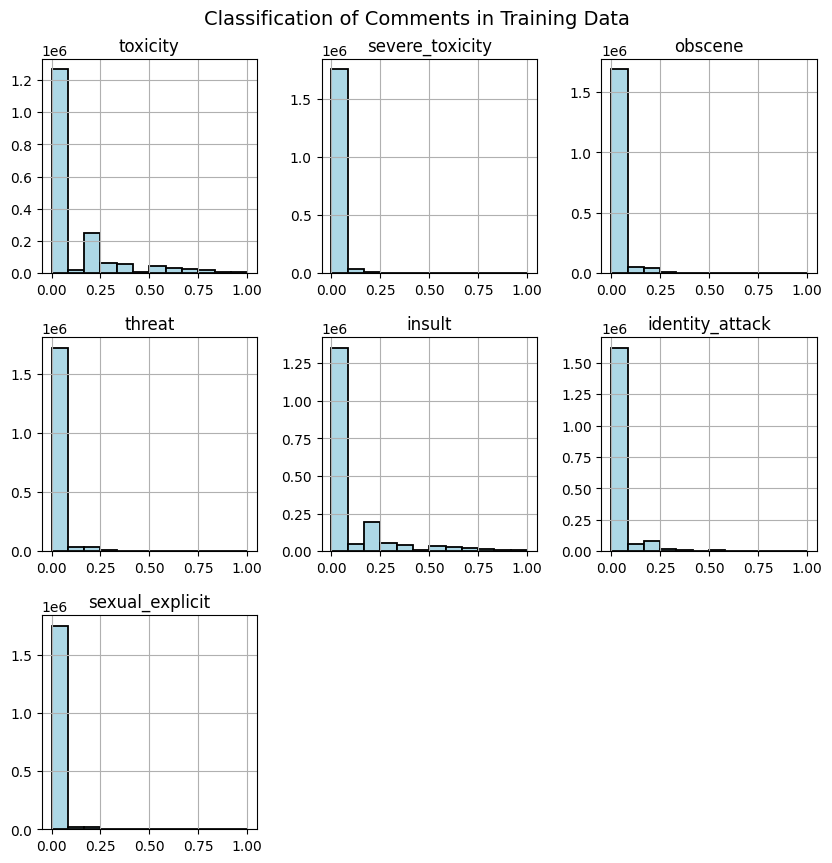

In [20]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
train_df.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)
plt.suptitle('Classification of Comments in Training Data',y = 0.93,size = 14)
plt.xlabel("Class")
plt.ylabel("Number of Comments")
plt.show()

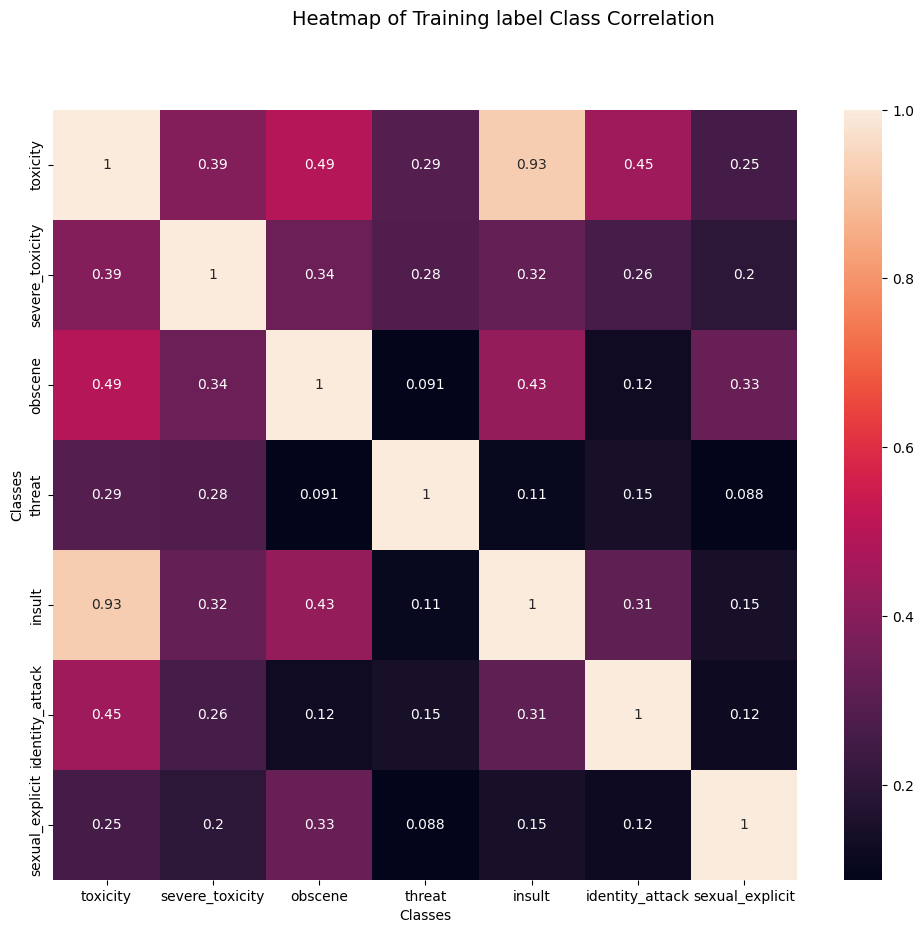

In [21]:
train_df_no_text = train_df.drop(columns=['text'])

fig = plt.figure(figsize = (12,10))
sns.heatmap(train_df_no_text.corr(), annot=True)
plt.suptitle('Heatmap of Training label Class Correlation',size = 14)
plt.xlabel("Classes")
plt.ylabel("Classes")
plt.show()

In [22]:
x=train_df['text']

In [23]:
# ## with evaluate and logging

# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# from collections import Counter
# from nltk.tokenize import word_tokenize
# from tqdm import tqdm

# # Hyperparameters
# MAX_FEATURES = 20000  # Maximum vocabulary size
# MAX_TEXT_LENGTH = 400  # Maximum sequence length
# EMBEDDING_DIM = 300  # GloVe embedding dimension
# BATCH_SIZE = 32
# N_EPOCHS = 5
# LEARNING_RATE = 0.02
# DROPOUT_RATE = 0.4
# FILTERS = 250
# KERNEL_SIZE = 3
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# # Step 1: Dataset Preparation
# class ToxicCommentsDataset(Dataset):
#     def _init_(self, texts, targets, vocab, max_len):
#         self.texts = texts
#         self.targets = targets
#         self.vocab = vocab
#         self.max_len = max_len

#     def _len_(self):
#         return len(self.texts)

#     def _getitem_(self, idx):
#         text = self.texts[idx]
#         tokens = [self.vocab.get(word, self.vocab["<UNK>"]) for word in word_tokenize(str(text).lower())]
#         padded_tokens = tokens[:self.max_len] + [0] * (self.max_len - len(tokens))
#         target = self.targets[idx] if self.targets is not None else [0] * 7
#         return torch.tensor(padded_tokens, dtype=torch.long), torch.tensor(target, dtype=torch.float)

# # Step 2: Tokenization and Vocabulary Building
# def build_vocab(texts, max_features):
#     all_tokens = [word for text in texts for word in word_tokenize(str(text).lower())]
#     most_common = Counter(all_tokens).most_common(max_features - 2)  # Reserve spots for PAD and UNK
#     vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
#     vocab["<PAD>"] = 0
#     vocab["<UNK>"] = 1
#     return vocab

# # Step 3: Load GloVe Embeddings
# def load_glove_embeddings(filepath, vocab, embedding_dim):
#     embeddings_index = {}
#     with open(filepath, "r", encoding="utf-8") as f:
#         for line in f:
#             values = line.split()
#             word = values[0]
#             coefs = np.asarray(values[1:], dtype="float32")
#             embeddings_index[word] = coefs

#     embedding_matrix = np.zeros((len(vocab), embedding_dim))
#     for word, idx in vocab.items():
#         if idx < len(vocab):
#             vector = embeddings_index.get(word)
#             if vector is not None:
#                 embedding_matrix[idx] = vector
#     return embedding_matrix

# # Step 4: CNN Model
# class CNNModel(nn.Module):
#     def _init_(self, vocab_size, embedding_dim, embedding_matrix, dropout_rate):
#         super(CNNModel, self)._init_()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
#         self.embedding.weight.requires_grad = False

#         self.conv1 = nn.Conv1d(embedding_dim, FILTERS, KERNEL_SIZE)
#         self.conv2 = nn.Conv1d(FILTERS, FILTERS, 5)
#         self.pool = nn.MaxPool1d(2)
#         self.global_pool = nn.AdaptiveMaxPool1d(1)

#         self.fc1 = nn.Linear(FILTERS, 250)
#         self.fc2 = nn.Linear(250, 7)
#         self.dropout = nn.Dropout(dropout_rate)
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.embedding(x).permute(0, 2, 1)  # (batch, embedding_dim, seq_len)
#         x = self.pool(self.relu(self.conv1(x)))
#         x = self.global_pool(self.relu(self.conv2(x))).squeeze(2)
#         x = self.relu(self.fc1(self.dropout(x)))
#         x = self.fc2(self.dropout(x))
#         return self.sigmoid(x)

# # Step 5: Training and Evaluation
# def evaluate_model(model, val_loader, criterion, device):
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for inputs, targets in val_loader:
#             inputs, targets = inputs.to(device), targets.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             val_loss += loss.item()
#     return val_loss / len(val_loader)

# def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs, device):
#     model.to(device)
#     for epoch in range(n_epochs):
#         # Training phase
#         model.train()
#         total_loss = 0
#         train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch")  # Progress bar
#         for inputs, targets in train_loader_tqdm:
#             inputs, targets = inputs.to(device), targets.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#             train_loader_tqdm.set_postfix({"Train Loss": total_loss / (train_loader_tqdm.n + 1)})

#         # Validation phase
#         val_loss = evaluate_model(model, val_loader, criterion, device)
#         print(f"Epoch {epoch + 1}/{n_epochs} - Train Loss: {total_loss / len(train_loader):.4f} - Val Loss: {val_loss:.4f}")

# # Step 6: Prediction and Submission
# def make_predictions(model, test_loader, device):
#     model.eval()
#     predictions = []
#     with torch.no_grad():
#         for inputs, _ in test_loader:
#             inputs = inputs.to(device)
#             outputs = model(inputs)
#             predictions.append(outputs.cpu().numpy())
#     return np.vstack(predictions)

# # Load Data
# train_df = pd.read_csv("/kaggle/input/data-255-toxic-comment-in-class-competition/train.csv")
# test_df = pd.read_csv("/kaggle/input/data-255-toxic-comment-in-class-competition/test.csv")

# # Preprocess Data
# x_train, x_val, y_train, y_val = train_test_split(train_df["text"], train_df.iloc[:, 2:].values, test_size=0.2, random_state=42)
# vocab = build_vocab(x_train, MAX_FEATURES)

# # Build Datasets and Dataloaders
# train_dataset = ToxicCommentsDataset(x_train.values, y_train, vocab, MAX_TEXT_LENGTH)
# val_dataset = ToxicCommentsDataset(x_val.values, y_val, vocab, MAX_TEXT_LENGTH)
# test_dataset = ToxicCommentsDataset(test_df["text"].values, None, vocab, MAX_TEXT_LENGTH)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# # Load GloVe Embeddings
# embedding_matrix = load_glove_embeddings("/kaggle/input/glove300/glove.42B.300d.txt", vocab, EMBEDDING_DIM)

# # Initialize Model, Loss, Optimizer
# model = CNNModel(len(vocab), EMBEDDING_DIM, embedding_matrix, DROPOUT_RATE)
# criterion = nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# # Train the Model
# train_model(model, train_loader, val_loader, criterion, optimizer, N_EPOCHS, DEVICE)

# # Make Predictions
# predictions = make_predictions(model, test_loader, DEVICE)
# binary_predictions = (predictions > 0.5).astype(int)

# # Save Submission
# submission = pd.DataFrame(binary_predictions, columns=['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity attack', 'sexual explicit'])
# submission['id'] = test_df['id']
# submission.to_csv("submission.csv", index=False)

# print("Submission saved to 'submission.csv'")

In [24]:
### with evaluate and logging

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# Hyperparameters
MAX_FEATURES = 20000  # Maximum vocabulary size
MAX_TEXT_LENGTH = 400  # Maximum sequence length
EMBEDDING_DIM = 300  # GloVe embedding dimension
BATCH_SIZE = 32
N_EPOCHS = 5
LEARNING_RATE = 0.02
DROPOUT_RATE = 0.4
FILTERS = 250
KERNEL_SIZE = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"



In [25]:
# Step 1: Dataset Preparation
class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, targets, vocab, max_len):
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = [self.vocab.get(word, self.vocab["<UNK>"]) for word in word_tokenize(str(text).lower())]
        padded_tokens = tokens[:self.max_len] + [0] * (self.max_len - len(tokens))
        target = self.targets[idx] if self.targets is not None else [0] * 7
        return torch.tensor(padded_tokens, dtype=torch.long), torch.tensor(target, dtype=torch.float)



In [26]:
# Step 2: Tokenization and Vocabulary Building
def build_vocab(texts, max_features):
    all_tokens = [word for text in texts for word in word_tokenize(str(text).lower())]
    most_common = Counter(all_tokens).most_common(max_features - 2)  # Reserve spots for PAD and UNK
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab



In [27]:
# Step 3: Load GloVe Embeddings
def load_glove_embeddings(filepath, vocab, embedding_dim):
    embeddings_index = {}
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.items():
        if idx < len(vocab):
            vector = embeddings_index.get(word)
            if vector is not None:
                embedding_matrix[idx] = vector
    return embedding_matrix




In [28]:
# Step 4: CNN Model
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, dropout_rate):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
        self.embedding.weight.requires_grad = False

        self.conv1 = nn.Conv1d(embedding_dim, FILTERS, KERNEL_SIZE)
        self.conv2 = nn.Conv1d(FILTERS, FILTERS, 5)
        self.pool = nn.MaxPool1d(2)
        self.global_pool = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(FILTERS, 250)
        self.fc2 = nn.Linear(250, 7)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)  # (batch, embedding_dim, seq_len)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.global_pool(self.relu(self.conv2(x))).squeeze(2)
        x = self.relu(self.fc1(self.dropout(x)))
        x = self.fc2(self.dropout(x))
        return self.sigmoid(x)



In [29]:
# Step 5: Training and Evaluation
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    return val_loss / len(val_loader)



In [30]:
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs, device):
    model.to(device)
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        total_loss = 0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch")  # Progress bar
        for inputs, targets in train_loader_tqdm:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            train_loader_tqdm.set_postfix({"Train Loss": total_loss / (train_loader_tqdm.n + 1)})

        # Validation phase
        val_loss = evaluate_model(model, val_loader, criterion, device)
        print(f"Epoch {epoch + 1}/{n_epochs} - Train Loss: {total_loss / len(train_loader):.4f} - Val Loss: {val_loss:.4f}")



In [31]:
# Step 6: Prediction and Submission
def make_predictions(model, test_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
    return np.vstack(predictions)



In [32]:
# # Load Data
train_df = pd.read_csv("/kaggle/input/data-255-toxic-comment-in-class-competition/train.csv")
test_df = pd.read_csv("/kaggle/input/data-255-toxic-comment-in-class-competition/test.csv")



In [33]:
train_df

,id,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,0,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,1,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,2,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,3,Is this something I'll be able to install on m...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4,4,haha you guys are a bunch of losers.,0.893617,0.021277,0.000000,0.0,0.872340,0.021277,0.0
...,...,...,...,...,...,...,...,...,...
1804869,1804869,"Maybe the tax on ""things"" would be collected w...",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1804870,1804870,What do you call people who STILL think the di...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1804871,1804871,"thank you ,,,right or wrong,,, i am following ...",0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1804872,1804872,Anyone who is quoted as having the following e...,0.621212,0.030303,0.030303,0.0,0.621212,0.045455,0.0


In [34]:
# Preprocess Data
x_train, x_val, y_train, y_val = train_test_split(train_df["text"], train_df.iloc[:, 2:].values, test_size=0.2, random_state=42)
vocab = build_vocab(x_train, MAX_FEATURES)
vocab


{'.': 2,
 'the': 3,
 ',': 4,
 'to': 5,
 'and': 6,
 'of': 7,
 'a': 8,
 'is': 9,
 'in': 10,
 'that': 11,
 'it': 12,
 'i': 13,
 'you': 14,
 'for': 15,
 '?': 16,
 'are': 17,
 'not': 18,
 "'s": 19,
 'be': 20,
 'have': 21,
 'on': 22,
 'they': 23,
 "''": 24,
 "n't": 25,
 'this': 26,
 '``': 27,
 'with': 28,
 'as': 29,
 'do': 30,
 'was': 31,
 'we': 32,
 'or': 33,
 '...': 34,
 'but': 35,
 'he': 36,
 '!': 37,
 'if': 38,
 'what': 39,
 'all': 40,
 'will': 41,
 'their': 42,
 'by': 43,
 'who': 44,
 'from': 45,
 'your': 46,
 'at': 47,
 'so': 48,
 'would': 49,
 'no': 50,
 'has': 51,
 ')': 52,
 'people': 53,
 'about': 54,
 'there': 55,
 '(': 56,
 'an': 57,
 'can': 58,
 'more': 59,
 'his': 60,
 'one': 61,
 'just': 62,
 'like': 63,
 'trump': 64,
 'out': 65,
 ':': 66,
 'when': 67,
 'our': 68,
 'up': 69,
 'how': 70,
 'my': 71,
 'them': 72,
 'get': 73,
 'should': 74,
 '-': 75,
 'did': 76,
 'than': 77,
 'were': 78,
 'does': 79,
 'us': 80,
 'been': 81,
 'only': 82,
 'any': 83,
 'some': 84,
 'time': 85,
 'other

In [35]:
# Build Datasets and Dataloaders
train_dataset = ToxicCommentsDataset(x_train.values, y_train, vocab, MAX_TEXT_LENGTH)
val_dataset = ToxicCommentsDataset(x_val.values, y_val, vocab, MAX_TEXT_LENGTH)
test_dataset = ToxicCommentsDataset(test_df["text"].values, None, vocab, MAX_TEXT_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)



In [36]:
# Load GloVe Embeddings
embedding_matrix = load_glove_embeddings("/kaggle/input/glove300/glove.42B.300d.txt", vocab, EMBEDDING_DIM)

embedding_matrix.shape



(20000, 300)

In [37]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.10876   ,  0.0022438 ,  0.22213   , ..., -0.29696   ,
         0.15939   , -0.14902   ],
       ...,
       [-0.58036   ,  0.0044031 ,  0.073849  , ..., -0.012734  ,
        -0.28838   , -0.41413   ],
       [ 0.072638  , -0.033721  ,  0.13586   , ..., -0.26308   ,
        -0.27801001,  0.43311   ],
       [-0.59485   , -0.19273999, -0.045942  , ..., -0.89568001,
         0.33482999, -0.36469999]])

In [38]:
# Initialize Model, Loss, Optimizer
model = CNNModel(len(vocab), EMBEDDING_DIM, embedding_matrix, DROPOUT_RATE)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)



In [39]:
train_loader

In [40]:
# Train the Model
train_model(model, train_loader, val_loader, criterion, optimizer, N_EPOCHS, DEVICE)



Epoch 1/5: 100%|██████████| 45122/45122 [18:19<00:00, 41.04batch/s, Train Loss=0.122]


Epoch 1/5 - Train Loss: 0.1224 - Val Loss: 0.1081


Epoch 2/5: 100%|██████████| 45122/45122 [18:13<00:00, 41.26batch/s, Train Loss=0.107]


Epoch 2/5 - Train Loss: 0.1066 - Val Loss: 0.1039


Epoch 3/5: 100%|██████████| 45122/45122 [18:11<00:00, 41.33batch/s, Train Loss=0.103]


Epoch 3/5 - Train Loss: 0.1035 - Val Loss: 0.1020


Epoch 4/5: 100%|██████████| 45122/45122 [18:11<00:00, 41.36batch/s, Train Loss=0.101]


Epoch 4/5 - Train Loss: 0.1014 - Val Loss: 0.1001


Epoch 5/5: 100%|██████████| 45122/45122 [18:18<00:00, 41.08batch/s, Train Loss=0.1]


Epoch 5/5 - Train Loss: 0.1000 - Val Loss: 0.0985


In [41]:
# Make Predictions
predictions = make_predictions(model, test_loader, DEVICE)
binary_predictions = (predictions > 0.5).astype(int)



In [42]:
# Save Submission
submission = pd.DataFrame(binary_predictions, columns=['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity attack', 'sexual explicit'])
submission['id'] = test_df['id']
submission.to_csv("submission.csv", index=False)

print("Submission saved to 'submission.csv'")

Submission saved to 'submission.csv'
